## **Import Libraries for processing gestures.**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json

## **Installing mediapipe for real time processing**

In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 34.5 MB/s eta 0:00:00


In [ ]:
import os

# **LOADING DATA**
- Listing files in dataset

In [ ]:
# Define paths
subsample_path = "/content/drive/MyDrive/ESOF 4559 - DSIP/Hand_Gesture_Dataset/ann_subsample"
train_path = "/content/drive/MyDrive/ESOF 4559 - DSIP/Hand_Gesture_Dataset/ann_train_val"
test_path = "/content/drive/MyDrive/ESOF 4559 - DSIP/Hand_Gesture_Dataset/ann_test"

# List files in subsample folder, train folder, and test folder
subsample_files = os.listdir(subsample_path)
test_files = os.listdir(test_path)
train_files = os.listdir(train_path)

#print the files
print("Files in subsample:", subsample_files)
print("Files in test:", test_files)
print("Files in train:", train_files)

Files in subsample: ['dislike.json', 'like.json', 'four.json', 'fist.json', 'call.json', 'mute.json', 'ok.json', 'rock.json', 'stop.json', 'three.json', 'three2.json', 'one.json', 'stop_inverted.json', 'peace_inverted.json', 'two_up.json', 'two_up_inverted.json', 'peace.json', 'palm.json']
Files in test: ['call.json', 'dislike.json', 'four.json', 'fist.json', 'mute.json', 'like.json', 'ok.json', 'peace.json', 'peace_inverted.json', 'rock.json', 'palm.json', 'one.json', 'stop_inverted.json', 'three2.json', 'three.json', 'two_up.json', 'stop.json', 'two_up_inverted.json']
Files in train: ['call.json', 'dislike.json', 'fist.json', 'four.json', 'like.json', 'mute.json', 'ok.json', 'one.json', 'palm.json', 'peace.json', 'peace_inverted.json', 'rock.json', 'stop.json', 'stop_inverted.json', 'three.json', 'three2.json', 'two_up.json', 'two_up_inverted.json']


**SAMPLE STRUCTURE OF DATASET**

## **Exploring Data - TRAIN SET**

- Dataset Structure, Class Distribution, Missing Data



In [ ]:
import json

#Load sample file from subsample dataset
sample_file = os.path.join(subsample_path, subsample_files[0])

with open(sample_file, 'r') as f:
  data = json.load(f)

for key, value in data.items():
  print(json.dumps({key: value}, indent=4))
  break

{
    "001c6f56-85cf-4e45-bfc1-1af53c0e501b": {
        "bboxes": [
            [
                0.29848959,
                0.56869285,
                0.07580751,
                0.06830282
            ],
            [
                0.47884104,
                0.3353942,
                0.08987013,
                0.09639664
            ]
        ],
        "labels": [
            "no_gesture",
            "dislike"
        ],
        "landmarks": [
            [
                [
                    0.3161945002509011,
                    0.5747586309383294
                ],
                [
                    0.33671233742343937,
                    0.5769192348260519
                ],
                [
                    0.3518242254286729,
                    0.5880937465712762
                ],
                [
                    0.3601643935333898,
                    0.6020037619463954
                ],
                [
                    0.36656230840300136,
   

In [ ]:
from collections import defaultdict
#Count the amount of gestures in Training Set
gesture_counts_train = defaultdict(int)

for file in train_files:
  file_path = os.path.join(train_path, file)

  with open(file_path, 'r') as f:
    data = json.load(f)

    for key, value in data.items():
      for gesture in value['labels']:
        gesture_counts_train[gesture] += 1

print(dict(gesture_counts_train))

{'call': 28194, 'no_gesture': 112740, 'dislike': 28536, 'fist': 27759, 'four': 28880, 'like': 27721, 'mute': 28971, 'ok': 27999, 'one': 28444, 'palm': 28326, 'peace': 28302, 'peace_inverted': 27864, 'rock': 27782, 'stop': 27961, 'stop_inverted': 28857, 'three': 28013, 'three2': 27789, 'two_up': 29679, 'two_up_inverted': 28236}


# **Visualization of Gesture Distribution**

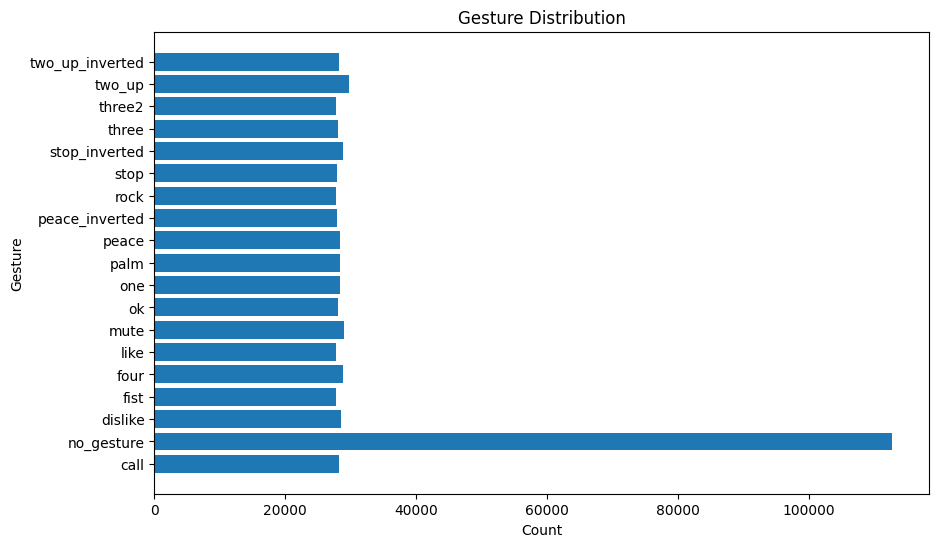

In [ ]:
#plotting count of each gesture
gestures = list(gesture_counts_train.keys())
counts = list(gesture_counts_train.values())

plt.figure(figsize=(10, 6))
plt.barh(gestures, counts)
plt.xlabel('Count')
plt.ylabel('Gesture')
plt.title('Gesture Distribution')
plt.show()

# **Hand Gesture Structure of Landmarks**

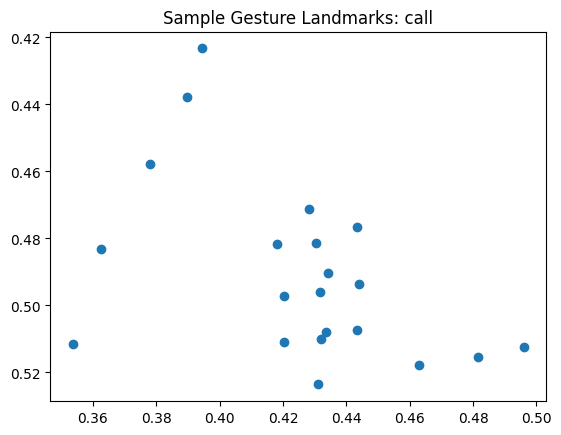

In [ ]:
def plot_landmarks(landmarks, title):
  x = [point[0] for point in landmarks]
  y = [point[1] for point in landmarks]
  plt.gca().invert_yaxis()
  plt.scatter(x, y)
  plt.title(title)
  plt.show()

#Use plot landmark function to show three2 gesture on a plot

sample_file = os.path.join(train_path, train_files[0])
with open(sample_file, 'r') as f:
  data = json.load(f)

sample_key = list(data.keys())[1]
gesture_label = data[sample_key]['labels'][0]
plot_landmarks(data[sample_key]['landmarks'][0], title =f"Sample Gesture Landmarks: {gesture_label}")

# **Data Preprocessing - Normalization**

Landmarks of each gesture are normalized in train dataset to standardize data of bounding boxes.

In [ ]:
def normalize_landmarks(landmarks, bbox):
  bbox_x, bbox_y, bbox_width, bbox_height = bbox
  return [[(x - bbox_x) / bbox_width, (y - bbox_y) / bbox_height] for x, y in landmarks]

normalized_train_data = []

for file in train_files:
  file_path = os.path.join(train_path, file)

  with open(file_path, 'r') as f:
    data = json.load(f)

    for key, value in data.items():
      bbox = value['bboxes'][0]
      normalized_landmarks = normalize_landmarks(value['landmarks'][0], bbox)
      normalized_train_data.append((value['labels'][0], normalized_landmarks))
print("Landmarks are Normalized!")

Landmarks are Normalized!


# **Checking for Missing Values**

In [ ]:
missing_data_counts = {
    "missing_bboxes": 0,
    "missing_labels": 0,
    "missing_landmarks": 0,
    "total_records": 0
}

def check_missing_values(file_path):
  with open(file_path, 'r') as f:
    data = json.load(f)

    for key, value in data.items():
      missing_data_counts["total_records"] += 1

      if 'bboxes' not in value or not value['bboxes']:
        missing_data_counts["missing_bboxes"] += 1

      if 'labels' not in value or not value['labels']:
        missing_data_counts["missing_labels"] += 1

      if 'landmarks' not in value or not value['landmarks']:
        missing_data_counts["missing_landmarks"] += 1

for folder in [train_path, test_path]:
  files = os.listdir(folder)
  for file in files:
    file_path = os.path.join(folder, file)
    check_missing_values(file_path)

# Print the summary of missing data
print("Missing Data Summary:")
print(f"Total records: {missing_data_counts['total_records']}")
print(f"Records with missing bounding boxes: {missing_data_counts['missing_bboxes']}")
print(f"Records with missing labels: {missing_data_counts['missing_labels']}")
print(f"Records with missing landmarks: {missing_data_counts['missing_landmarks']}")

Missing Data Summary:
Total records: 552992
Records with missing bounding boxes: 0
Records with missing labels: 0
Records with missing landmarks: 0


# **EDA on Test Data - Consistency Check**
- Test and Train data are already split in different folders from dataset.

In [ ]:
#Count the amount of gestures in Training Set
gesture_counts_test = defaultdict(int)

for file in test_files:
  file_path = os.path.join(test_path, file)

  with open(file_path, 'r') as f:
    data = json.load(f)

    for key, value in data.items():
      for gesture in value['labels']:
        gesture_counts_test[gesture] += 1
print("Test set gesture counts:")
print(dict(gesture_counts_test))

Test set gesture counts:
{'peace_inverted': 2278, 'no_gesture': 10849, 'one': 2462, 'like': 2415, 'three2': 2332, 'fist': 2506, 'ok': 2391, 'four': 2492, 'stop_inverted': 2469, 'call': 2436, 'two_up_inverted': 2229, 'two_up': 2545, 'palm': 2427, 'rock': 2413, 'mute': 2438, 'peace': 2477, 'dislike': 2551, 'three': 2408, 'stop': 2400}


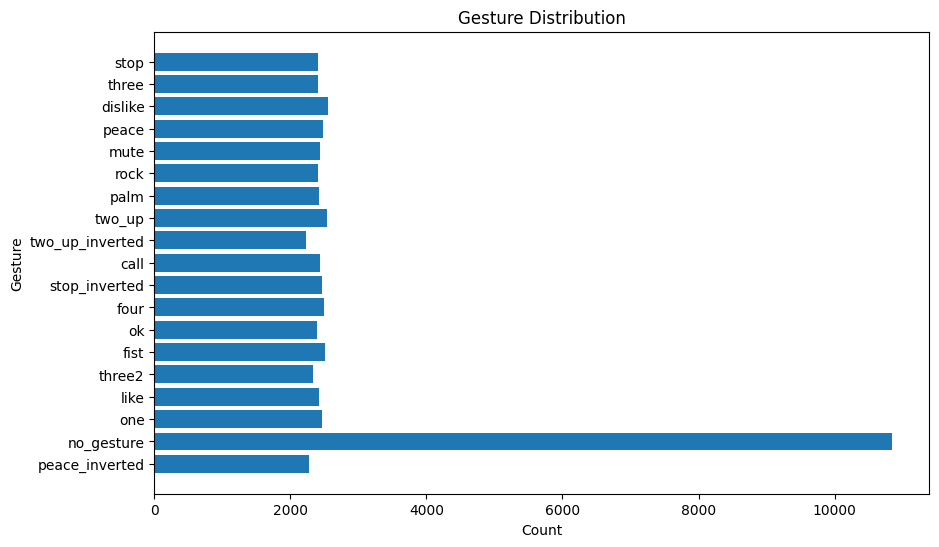

In [ ]:
#plotting count of each gesture
gestures_test = list(gesture_counts_test.keys())
counts_test = list(gesture_counts_test.values())

plt.figure(figsize=(10, 6))
plt.barh(gestures_test, counts_test)
plt.xlabel('Count')
plt.ylabel('Gesture')
plt.title('Gesture Distribution')
plt.show()

# **Train Modeling**
- EDA is complete.


In [ ]:
import numpy as np
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [ ]:
for idx, item in enumerate(normalized_train_data):
    try:
        flattened = np.array(item[1]).flatten()
    except Exception as e:
        print(f"Error at index {idx}: {e}")
        print(f"Problematic item: {item}")


In [ ]:
# Filter out invalid data
valid_normalized_train_data = [
    (label, landmarks) for label, landmarks in normalized_train_data
    if isinstance(landmarks, list) and len(landmarks) == 21 and all(len(point) == 2 for point in landmarks)
]


In [ ]:
# Flatten landmarks
X = np.array([np.array(item[1]).flatten() for item in valid_normalized_train_data])  # Features
y = np.array([item[0] for item in valid_normalized_train_data])  # Labels

print(f"Feature shape: {X.shape}")  # Should be (number of samples, 42)
print(f"Labels shape: {y.shape}")  # Should match the number of samples



Feature shape: (498450, 42)
Labels shape: (498450,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to one-hot encoding
y_one_hot = to_categorical(y_encoded)

print(f"One-hot encoded labels shape: {y_one_hot.shape}")  # Should match (498450, number of classes)


One-hot encoded labels shape: (498450, 19)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y_one_hot, test_size=0.2, stratify=y, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Training data shape: (398760, 42)
Validation data shape: (99690, 42)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the Feedforward Neural Network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer
    Dropout(0.3),  # Regularization
    Dense(64, activation='relu'),  # Hidden layer
    Dropout(0.3),  # Regularization
    Dense(y_train.shape[1], activation='softmax')  # Output layer for classification
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │           5,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 19)                  │           1,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,995 (58.57 KB)

 Trainable params: 14,995 (58.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=5,  # Adjust as needed
                    batch_size=32,
                    verbose=1)


Epoch 1/5
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.7862 - loss: 0.6513 - val_accuracy: 0.9821 - val_loss: 0.0730
Epoch 2/5
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 40s 3ms/step - accuracy: 0.9684 - loss: 0.1232 - val_accuracy: 0.9854 - val_loss: 0.0600
Epoch 3/5
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9736 - loss: 0.1025 - val_accuracy: 0.9860 - val_loss: 0.0565
Epoch 4/5
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - accuracy: 0.9757 - loss: 0.0950 - val_accuracy: 0.9867 - val_loss: 0.0534
Epoch 5/5
12462/12462 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.9776 - loss: 0.0880 - val_accuracy: 0.9875 - val_loss: 0.0493


In [ ]:
# Save the trained model
model.save('gesture_recognition_model.h5')
print("Model saved as gesture_recognition_model.h5")


Model saved as gesture_recognition_model.h5


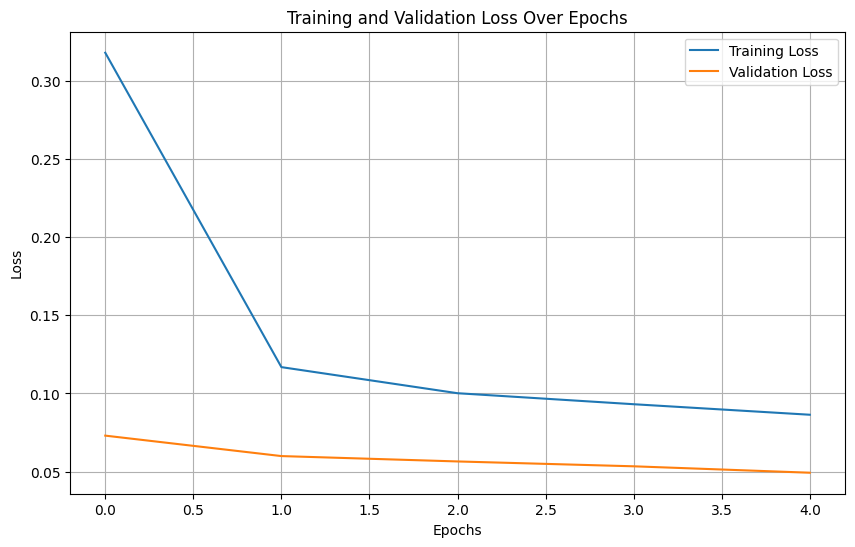

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


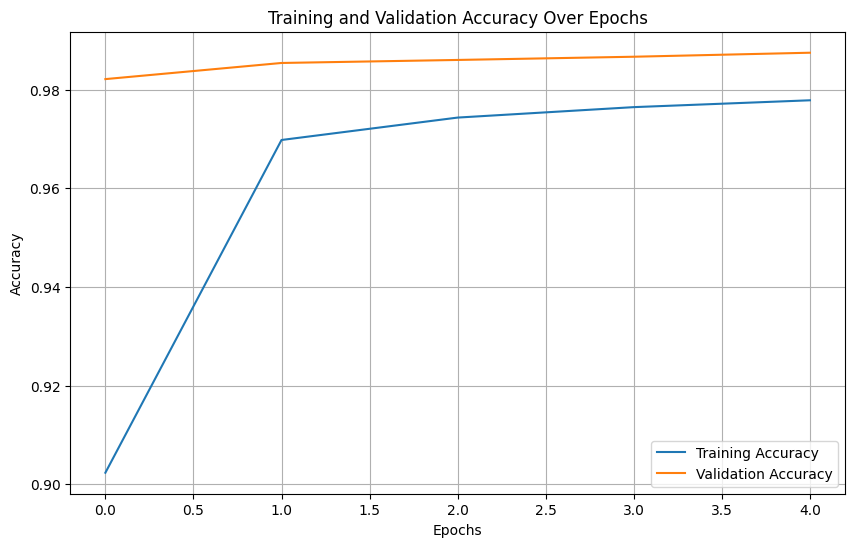

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Validation accuracy
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
